In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle
import scipy
import datetime
import torch
import xarray

sys.path.append("..")
from pathlib import Path
from ruamel.yaml import YAML
from functions_evaluation import nse
from neuralhydrology.utils.config import Config
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.datasetzoo.camelsus import load_camels_us_forcings

Part 1. Initialize information

In [2]:
# paths to access the information
path_entities = "../data/basin_id/basins_camels_us_531.txt"
path_data = "../data/CAMELS_US"
path_additional_features = "../data/CAMELS_US/pet_hargreaves.pickle"

color_palette = {
    "observed": "#1f77b4",
    "LSTM": "#2ca02c",
    "Hybrid": "#ff7f0e",
    "HBV": "#d62728",
    "benchmark": "#9467bd"
    }

path_train_split = "../data/CAMELS_US/train_split_file_new.p"
path_test_split = "../data/CAMELS_US/test_split_file_new.p"
path_discharge_statistics = "../data/CAMELS_US/camels_daily_return_periods.csv"
path_results_HBV = "../Hy2DL/results/HBV_extrapolation/"
path_results_hybrid = "../experiments/runs/hybrid_extrapolation_0607_111126/test/model_epoch020/test_results.p"

# Ensemble of LSTMs
path_results_LSTM = ["../experiments/runs/lstm_extrapolation_seed_100_0807_151158",
                      "../experiments/runs/lstm_extrapolation_seed_200_0807_172235",
                      "../experiments/runs/lstm_extrapolation_seed_300_0807_192832",
                      "../experiments/runs/lstm_extrapolation_seed_400_0807_213630",
                      "../experiments/runs/lstm_extrapolation_seed_500_0807_234238"]

# Whole period in which the hybrid models were run during testing. We then filter the dates of the specific testing
# periods. 1980-12-31 is the first day in which we can make a prediction, because the data starts at 1980-01-01.
time_period = ["1980-12-31","2014-09-30"] 
full_date_range = pd.date_range(start=time_period[0], end=time_period[1])

Part 2. Read training/testing split and generate the associated time series for each basin

In [3]:
# Training period ----------------------------------------------------------------------------------------------------
with open(path_train_split, "rb") as f:
    # Load the object from the pickle file
    dict_train= pickle.load(f)
dates_per_basin_training = {}
for basin, values in dict_train.items():
    date_ranges = []
    for i, start_date in enumerate(values["start_dates"]):
        date_range = pd.date_range(start_date, values["end_dates"][i])
        date_ranges.append(date_range) 
    continuous_series = pd.concat([pd.DataFrame(date_range, columns=["date"]) for date_range in date_ranges])
    continuous_series = continuous_series.drop_duplicates()
    continuous_series.reset_index(drop=True, inplace=True)
    dates_per_basin_training[basin] = continuous_series

# Testing period ----------------------------------------------------------------------------------------------------
with open(path_test_split, "rb") as f:
    # Load the object from the pickle file
    dict_test= pickle.load(f)
dates_per_basin_testing = {}
for basin, values in dict_test.items():
    date_ranges = []
    for i, start_date in enumerate(values["start_dates"]):
        date_range = pd.date_range(start_date, values["end_dates"][i])
        date_ranges.append(date_range)
    continuous_series = pd.concat([pd.DataFrame(date_range, columns=["date"]) for date_range in date_ranges])
    continuous_series = continuous_series.drop_duplicates()
    continuous_series.reset_index(drop=True, inplace=True)
    dates_per_basin_testing[basin] = continuous_series

# Print statistics of training/testing time periods
total_years_training = sum(len(values["start_dates"]) for values in dict_train.values())
total_years_testing = sum(len(values["start_dates"]) for values in dict_test.values())
print(f"Total training years: {total_years_training},  average training years per basin: {round(total_years_training/len(dict_train),1)}")
print(f"Total testing years: {total_years_testing},  average testing years per basin: {round(total_years_testing/len(dict_test),1)}")

Total training years: 9489,  average training years per basin: 17.9
Total testing years: 3429,  average testing years per basin: 6.5


Part 3. Read and process the results of the different models

In [4]:
# Read information produced by HBV ---------------------------------------------------------------------------------
with open(path_results_HBV+"HBV_results.pickle", "rb") as f:
    hbv_results = pickle.load(f)

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test/model_epoch020/test_results.p", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["1D"]["xr"]["QObs(mm/d)_sim"].to_pandas().iloc[:,0]
        if i == 0: # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[:,0]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i+1}": y_sim}, index=y_obs.index)
        else: # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i+1}"] = y_sim
# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]['y_sim'] = lstm_results[basin][y_sim_columns].median(axis=1)

# Read information produced by hybrid and store it in dictionary of dataframes -------------------------------------
with open(path_results_hybrid, "rb") as f:
    info_hybrid= pickle.load(f)
hybrid_results = {} # results only for testing period
for basin in info_hybrid.keys():
    y_obs = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[0].values
    y_sim = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_sim"].to_pandas().iloc[0].values
    hybrid_results[basin] = pd.DataFrame(data={"y_obs": y_obs[full_date_range.isin(dates_per_basin_testing[basin]['date'])], 
                                               "y_sim": y_sim[full_date_range.isin(dates_per_basin_testing[basin]['date'])]}, 
                                               index= full_date_range[full_date_range.isin(dates_per_basin_testing[basin]['date'])])
    
# observed discharges for the whole time period (training and testing) -----------------------------------------------
observed_values = {} 
for basin in info_hybrid.keys():
    y_obs = info_hybrid[basin]["1D"]["xr"]["QObs(mm/d)_obs"].to_pandas().iloc[0].values
    observed_values[basin] = pd.DataFrame(data={"y_obs": y_obs}, index=full_date_range)

Part 4. Visualize training - testing split

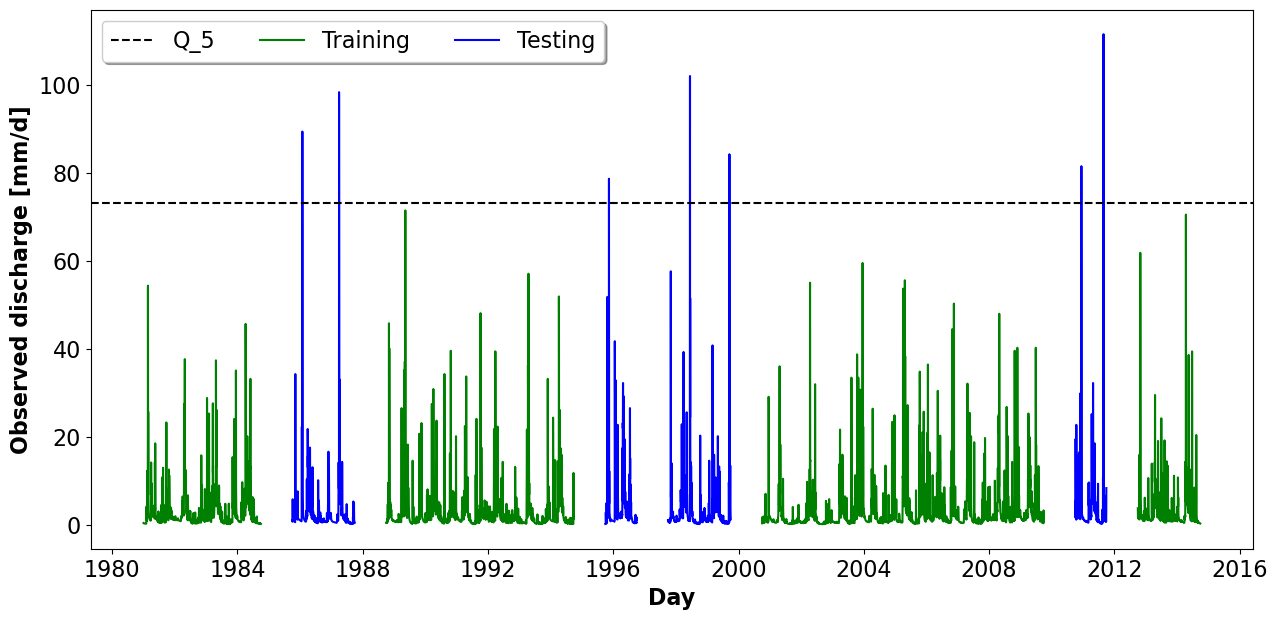

In [5]:
basin_to_analyze = "01054200"
plt.rcParams["figure.figsize"] = (15, 7)

# Training
for i, start_date in enumerate(dict_train[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_train[basin_to_analyze]["end_dates"][i])
    df_training = observed_values[basin_to_analyze]["y_obs"][observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)]
    plt.plot(df_training, color="g")
        
# Testing
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_testing = observed_values[basin_to_analyze]["y_obs"][observed_values[basin_to_analyze]["y_obs"].index.isin(date_range)]
    plt.plot(df_testing, color="b")

# 5 year return period line
discharge_statistics = pd.read_csv(path_discharge_statistics)
discharge_statistics["basin"] = discharge_statistics["basin"].str.replace("CAMELS_", "")
discharge_statistics.set_index("basin", inplace=True)
plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--", label = "Q_5")

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c="g", label="Training")
plt.plot([], c="b", label="Testing")

# Format plot
plt.xlabel("Day", fontsize=16, fontweight="bold")
plt.ylabel("Observed discharge [mm/d]", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=16)
plt.legend(loc="upper left",fontsize=16, shadow=True, ncol=3)
plt.savefig("TrainingTestingSplit.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 5. Overall model comparison

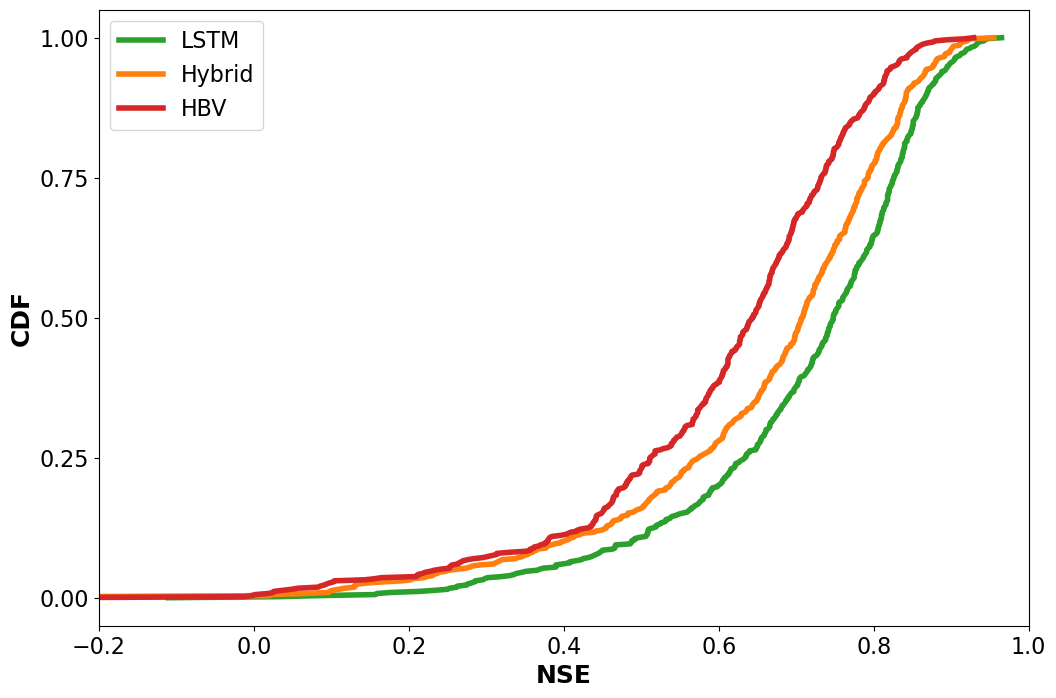

Median NSE LSTM: 0.75
Median NSE Hybrid: 0.71
Median NSE HBV: 0.64


In [26]:
df_NSE_lstm = pd.DataFrame(data={'basin_id': list(lstm_results.keys()), 
                                 'NSE_LSTM': np.round(nse(df_results=lstm_results, average=False),3)}).set_index('basin_id')

df_NSE_hybrid = pd.DataFrame(data={'basin_id': list(hybrid_results.keys()), 
                                   'NSE_Hybrid': np.round(nse(df_results=hybrid_results, average=False),3)}).set_index('basin_id')

df_NSE_hbv = pd.DataFrame(data={'basin_id': list(hbv_results.keys()), 
                                'NSE_HBV': np.round(nse(df_results=hbv_results, average=False),3)}).set_index('basin_id')

df_NSE_comparison = pd.concat([df_NSE_hybrid, df_NSE_lstm, df_NSE_hbv], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

#Create plot
plt.rcParams["figure.figsize"]=(12,8)

plt.plot(df_NSE_comparison["NSE_LSTM"], df_NSE_comparison["cdf"], label="LSTM", linewidth=4, color=color_palette["LSTM"])
plt.plot(df_NSE_comparison["NSE_Hybrid"], df_NSE_comparison["cdf"], label="Hybrid", linewidth=4 , color=color_palette["Hybrid"])
plt.plot(df_NSE_comparison["NSE_HBV"], df_NSE_comparison["cdf"], label="HBV", linewidth=4 , color=color_palette["HBV"])


plt.xlim(-0.2, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)    
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
plt.savefig("CDF_NSE.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

print(f'Median NSE LSTM: {"%.2f" % df_NSE_comparison["NSE_LSTM"].median()}\
\nMedian NSE Hybrid: {"%.2f" % df_NSE_comparison["NSE_Hybrid"].median()}\
\nMedian NSE HBV: {"%.2f" % df_NSE_comparison["NSE_HBV"].median()}')

Part 6. Peak analysis for observed data

In [7]:
peak_threshold = "1.01"
obs_peaks_per_basin = {}
for basin, df in hybrid_results.items():
    peaks_loc, _ = scipy.signal.find_peaks(df["y_obs"].values, 
                                           distance=7,
                                           prominence=np.std(df["y_obs"].values))
    
    peaks = df.iloc[peaks_loc]["y_obs"]
    
    mask = peaks > discharge_statistics.loc[basin, peak_threshold]
    obs_peaks_per_basin[basin] = {"value": peaks.values[mask],
                                  "date": peaks.index[mask]}

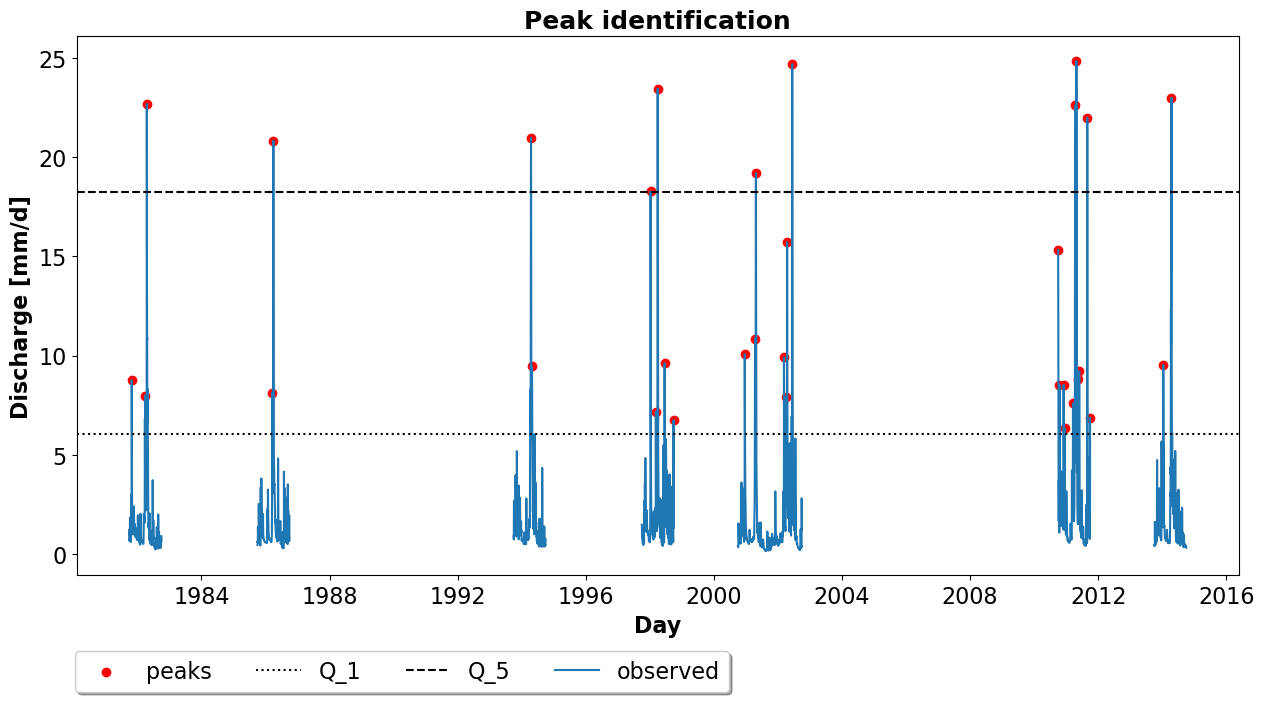

In [8]:
# Plot simulated and observed discharges
basin_to_analyze = "04296000" # 01022500 01073000 08200000 01435000
plt.rcParams["figure.figsize"] = (15, 7)

# Observed
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_obs = hybrid_results[basin_to_analyze]["y_obs"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    plt.plot(df_obs.index, df_obs, color=color_palette["observed"])

plt.scatter(obs_peaks_per_basin[basin_to_analyze]["date"], obs_peaks_per_basin[basin_to_analyze]["value"], marker="o", 
            label="peaks", color="r")

plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "1.01"], color="black", linestyle="dotted", label = "Q_1")
plt.axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--", label = "Q_5")

plt.plot([], color=color_palette["observed"], label="observed")

# Format plot
plt.xlabel("Day", fontsize=16, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=16, fontweight="bold")
plt.title("Peak identification", fontsize=18, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=16)
plt.legend(loc="upper center", bbox_to_anchor=(0.28, -0.12),fontsize=16, shadow=True, ncol=4)

Part 7. Peak identification for the different models

In [9]:
hybrid_peaks_per_basin = {}
tolerance = 2 # we use the id of the observed peaks plus a +-2 day window to identify the associated peak in the simulation

# Hybrid model -------------------------------------------------------------------------------------------------------
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = hybrid_results[basin]["y_sim"].loc[date-pd.Timedelta(days=tolerance):
                                                       date+pd.Timedelta(days=tolerance)]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])

    hybrid_peaks_per_basin[basin] ={"value": max_value,
                                    "date": max_value_dates}

# LSTM model -------------------------------------------------------------------------------------------------------
lstm_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = lstm_results[basin]["y_sim"].loc[date-pd.Timedelta(days=tolerance):
                                                     date+pd.Timedelta(days=tolerance)]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])
        
    lstm_peaks_per_basin[basin] ={"value": max_value,
                                  "date": max_value_dates}

# HBV model -------------------------------------------------------------------------------------------------------
hbv_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    max_value = []
    max_value_dates = []
    for date in peak_info["date"]:
        window_df = hbv_results[basin]["y_sim"].loc[date-pd.Timedelta(days=tolerance):
                                                    date+pd.Timedelta(days=tolerance)]
        max_value_dates.append(window_df.idxmax())
        max_value.append(window_df.loc[window_df.idxmax()])
    
    hbv_peaks_per_basin[basin] ={"value": max_value,
                                 "date": max_value_dates}

Part 8. Peak analysis: Absolute percentage error

In [10]:
perc_error_peaks = {}
for basin, peak_info in obs_peaks_per_basin.items():
    obs_peaks = peak_info["value"]
    lstm_peaks = np.array(lstm_peaks_per_basin[basin]["value"])
    hybrid_peaks =  np.array(hybrid_peaks_per_basin[basin]["value"])
    hbv_peaks =  np.array(hbv_peaks_per_basin[basin]["value"])

    perc_error_peaks[basin] = {"LSTM": np.abs(obs_peaks-lstm_peaks)/obs_peaks,
                               "Hybrid": np.abs(obs_peaks-hybrid_peaks)/obs_peaks,
                               "HBV": np.abs(obs_peaks-hbv_peaks)/obs_peaks
                               }

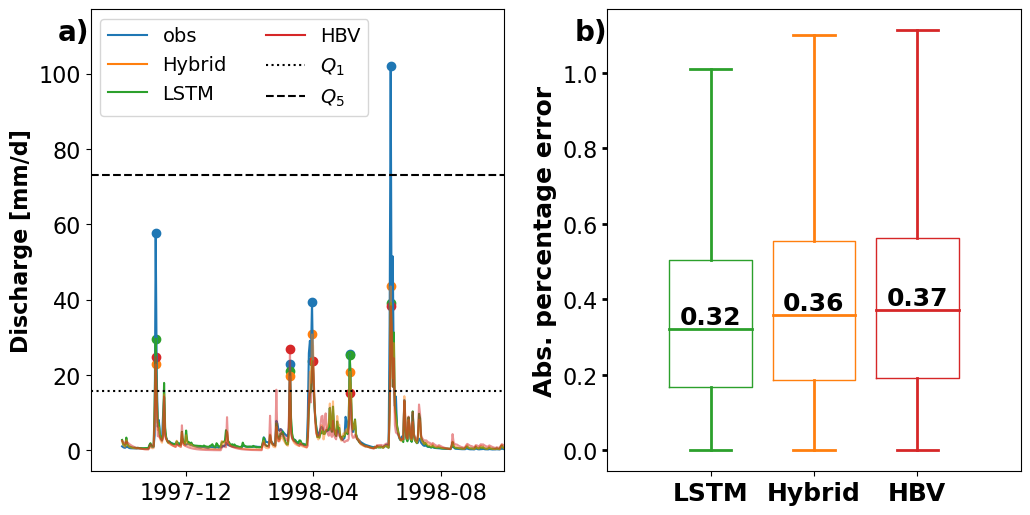

In [11]:
basin_to_analyze = "01054200"

# Concatenate all the errors, of each model, in a list
perc_error_peaks_lstm = []
perc_error_peaks_hybrid = []
perc_error_peaks_hbv = []
for key, peak_error in perc_error_peaks.items():
    perc_error_peaks_lstm.extend(peak_error["LSTM"])
    perc_error_peaks_hybrid.extend(peak_error["Hybrid"])
    perc_error_peaks_hbv.extend(peak_error["HBV"])


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Observed data ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_obs = hybrid_results[basin_to_analyze]["y_obs"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    axs[0].plot(df_obs.index, df_obs, color=color_palette["observed"])
axs[0].scatter(obs_peaks_per_basin[basin_to_analyze]["date"], obs_peaks_per_basin[basin_to_analyze]["value"], 
               marker="o", color=color_palette["observed"])

# LSTM ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_lstm = lstm_results[basin_to_analyze]["y_sim"][lstm_results[basin_to_analyze].index.isin(date_range)]
    axs[0].plot(df_lstm.index, df_lstm, color=color_palette["LSTM"])
axs[0].scatter(lstm_peaks_per_basin[basin_to_analyze]["date"], lstm_peaks_per_basin[basin_to_analyze]["value"],
               marker="o", color=color_palette["LSTM"])

# Hybrid ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hybrid_results[basin_to_analyze]["y_sim"][hybrid_results[basin_to_analyze].index.isin(date_range)]
    axs[0].plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["Hybrid"])
axs[0].scatter(hybrid_peaks_per_basin[basin_to_analyze]["date"], hybrid_peaks_per_basin[basin_to_analyze]["value"], 
               marker="o", color=color_palette["Hybrid"])

# HBV ------------------------------------------------------------------------------------------------------
for i, start_date in enumerate(dict_test[basin_to_analyze]["start_dates"]):
    date_range = pd.date_range(start_date, dict_test[basin_to_analyze]["end_dates"][i])
    df_hyb = hbv_results[basin_to_analyze]["y_sim"][hbv_results[basin_to_analyze].index.isin(date_range)]
    axs[0].plot(df_hyb.index, df_hyb, alpha=0.5, color=color_palette["HBV"])
axs[0].scatter(hbv_peaks_per_basin[basin_to_analyze]["date"], hbv_peaks_per_basin[basin_to_analyze]["value"], 
               marker="o", color=color_palette["HBV"])

# Add return period limit
axs[0].axhline(y=discharge_statistics.loc[basin_to_analyze, "1.01"], color="black", linestyle="dotted")
axs[0].axhline(y=discharge_statistics.loc[basin_to_analyze, "5"], color="black", linestyle="--")

# Dummy plots for legend
axs[0].plot([], color=color_palette["observed"], label="obs")
axs[0].plot([], color=color_palette["Hybrid"], label="Hybrid")
axs[0].plot([], color=color_palette["LSTM"], label="LSTM")
axs[0].plot([], color=color_palette["HBV"], label="HBV")
axs[0].plot([], color="black", linestyle="dotted", label = r"$Q_1$")
axs[0].plot([], color="black", linestyle="--", label = r"$Q_5$")

# Format plot
axs[0].text(-0.08, 0.98, "a)", transform=axs[0].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[0].set_ylabel("Discharge [mm/d]", fontsize=16, fontweight="bold")
axs[0].tick_params(axis="both", which="major", labelsize=16)
axs[0].set_xlim(datetime.datetime(1997, 9, 1), datetime.datetime(1998, 9, 30))
axs[0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))  # Change interval to 3 months
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axs[0].legend(fontsize=14, ncol=2, loc="upper left")

# Boxplots for absolute percentage errors
axs[1].boxplot(perc_error_peaks_lstm, positions=[0.4], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["LSTM"]), 
            medianprops=dict(color=color_palette["LSTM"], linewidth=2),
            whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
            capprops=dict(color=color_palette["LSTM"], linewidth=2))
axs[1].boxplot(perc_error_peaks_hybrid, positions=[0.5], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["Hybrid"]), 
            medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
            whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
            capprops=dict(color=color_palette["Hybrid"], linewidth=2))
axs[1].boxplot(perc_error_peaks_hbv, positions=[0.6], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["HBV"]), 
            medianprops=dict(color=color_palette["HBV"], linewidth=2),
            whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
            capprops=dict(color=color_palette["HBV"], linewidth=2))


axs[1].text(-0.08, 0.98, "b)", transform=axs[1].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[1].set_xlim(left=0.3, right=0.7)
axs[1].set_xticks([0.4, 0.5, 0.6], update_limits=False)
axs[1].set_xticklabels(["LSTM", "Hybrid", "HBV"], fontsize=18, fontweight="bold")
axs[1].set_ylabel("Abs. percentage error", fontsize=18, fontweight="bold")
axs[1].tick_params(axis="y", which="major", labelsize=16, width=2)
axs[1].text(0.4, np.median(perc_error_peaks_lstm), f"{np.median(perc_error_peaks_lstm):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")
axs[1].text(0.5, np.median(perc_error_peaks_hybrid), f"{np.median(perc_error_peaks_hybrid):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")
axs[1].text(0.6, np.median(perc_error_peaks_hbv), f"{np.median(perc_error_peaks_hbv):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")

plt.subplots_adjust(wspace=0.25)
plt.savefig("PeakIdentification_PeakError.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 9. Peak analysis: Absolute percentage error - by return period

In [12]:
# Classified observed peaks based on their return period
classified_peaks = {}
for basin, peak_info in obs_peaks_per_basin.items():
    peaks = peak_info["value"]

    # Return periods per basin
    TR_1 = discharge_statistics.loc[basin, "1.01"]
    TR_5 = discharge_statistics.loc[basin, "5"]
    TR_25 = discharge_statistics.loc[basin, "25"]
    TR_50 = discharge_statistics.loc[basin, "50"]
    TR_100 = discharge_statistics.loc[basin, "100"]

    # Classify the values of the "peaks" vector
    classification = np.zeros_like(peaks)
    classification[(peaks >= TR_1) & (peaks < TR_5)] = 1
    classification[(peaks >= TR_5) & (peaks < TR_25)] = 2
    classification[(peaks >= TR_25) & (peaks < TR_50)] = 3
    classification[(peaks >= TR_50) & (peaks < TR_100)] = 4
    classification[peaks >= TR_100] = 5

    classified_peaks[basin] = classification


model_name =  ["LSTM", "Hybrid", "HBV"]
TR_range=["1-5", "5-25","25-50","50-100","100+"]
error_per_TR = {}
for TR in TR_range :
    error_per_TR[TR] = []

# Intialize structure to save error per model and per return period
error_per_model = {model: {TR: [] for TR in TR_range} for model in model_name}
# Process and store the error per model per return period
for basin, peak_error_per_model in perc_error_peaks.items():
    for model in peak_error_per_model.keys():
        for i, TR in enumerate(TR_range):
            error_per_model[model][TR].extend(peak_error_per_model[model][classified_peaks[basin]==i+1])

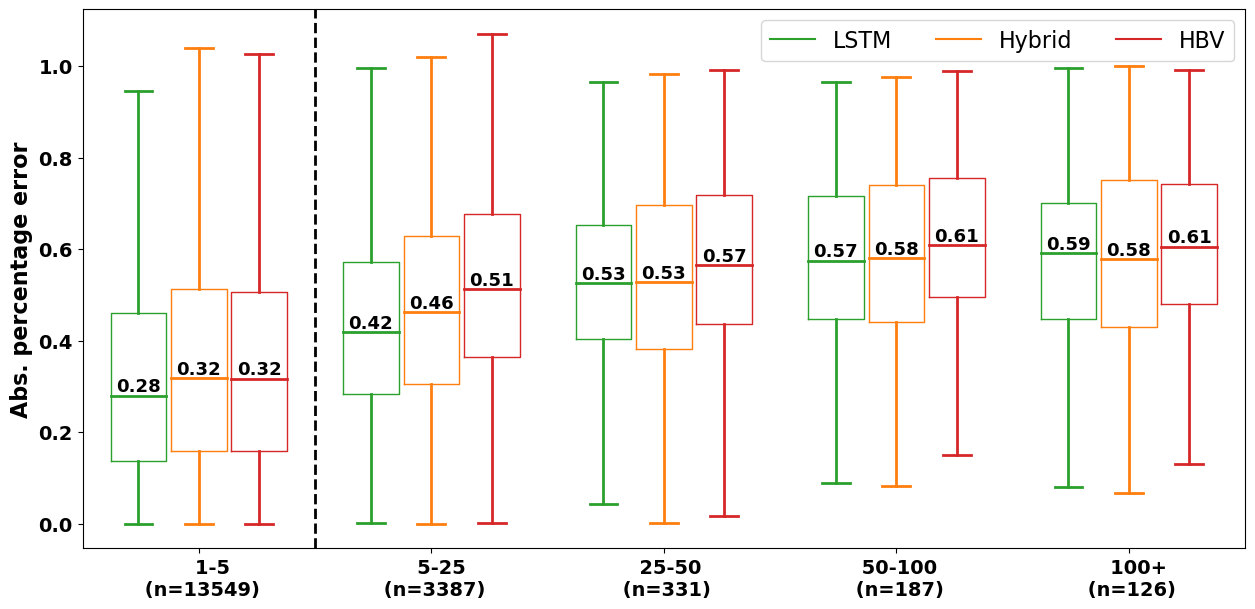

In [13]:
# Assuming ri_list is a dictionary containing data for different models
step = 0.5
bin_names = [f"{TR_range[i]:>7}\n (n={len(value)})" for i, (_, value) in enumerate(error_per_model['Hybrid'].items())]
x = np.arange(0, len(list(bin_names))*step, step)  # the label locations
width = 0.13  # Width of each boxplot

# Iterate through each bin_name and create boxplots for each model
for i, TR in enumerate(TR_range):
    # LSTM boxplots
    errors_lstm = error_per_model[f"LSTM"][TR]
    plt.boxplot(errors_lstm, 
                    positions=[x[i] - width], showfliers=False, widths=0.12, patch_artist=False, 
                    boxprops=dict(color=color_palette["LSTM"]), 
                    medianprops=dict(color=color_palette["LSTM"], linewidth=2),
                    whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
                    capprops=dict(color=color_palette["LSTM"], linewidth=2))
    
    plt.text(x[i] - width, np.median(errors_lstm), f"{np.median(errors_lstm):.2f}", horizontalalignment="center", 
                verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
    
    # Hybrid boxplots
    errors_hybrid = error_per_model["Hybrid"][TR]
    plt.boxplot(errors_hybrid, 
                    positions=[x[i]], showfliers=False, widths=0.12, patch_artist=False, 
                    boxprops=dict(color=color_palette["Hybrid"]), 
                    medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
                    whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
                    capprops=dict(color=color_palette["Hybrid"], linewidth=2))
    
    plt.text(x[i], np.median(errors_hybrid), f"{np.median(errors_hybrid):.2f}", horizontalalignment="center", 
                verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
    
    # HBV boxplots
    errors_hbv = error_per_model["HBV"][TR]
    plt.boxplot(errors_hbv, 
                    positions=[x[i] + width], showfliers=False, widths=0.12, patch_artist=False, 
                    boxprops=dict(color=color_palette["HBV"]), 
                    medianprops=dict(color=color_palette["HBV"], linewidth=2),
                    whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
                    capprops=dict(color=color_palette["HBV"], linewidth=2))
    
    plt.text(x[i] + width, np.median(errors_hbv), f"{np.median(errors_hbv):.2f}", horizontalalignment="center", 
                verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
    
# Line dividing interpolation - extrapolation errors
plt.axvline(x=0.25, color="black", linestyle="--", linewidth=2)

# Dummy plots for the legend
plt.plot([], c=color_palette["LSTM"], label="LSTM")
plt.plot([], c=color_palette["Hybrid"], label="Hybrid")
plt.plot([], c=color_palette["HBV"], label="HBV")

# Add labels, titles, legends, etc. as needed
plt.xticks(x, bin_names, fontsize=14, fontweight="bold")
plt.xlim(left = x[0]-step/2, right=x[-1]+step/2)  
plt.ylabel("Abs. percentage error", fontsize=16, fontweight="bold")
plt.yticks(fontsize=14, fontweight="bold")
plt.legend(loc="upper right",fontsize=16, ncol=4)
plt.savefig("PeakError_per_return_period.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 10. Saturation Analysis

In [14]:
# Training values
obs_in_training = []
for basin, df in observed_values.items():
    obs_in_training.extend(df['y_obs'][df['y_obs'].index.isin(dates_per_basin_training[basin].values.flatten())].values)

# Highest "n" values in testing -------------------------------------------------------------------------------------
n = 531
obs_peaks_testing = []
obs_peaks_date_testing = []
obs_peaks_associated_basin = []
for basin, value in obs_peaks_per_basin.items():
    obs_peaks_testing.extend(value["value"])
    obs_peaks_date_testing.extend(value["date"])
    obs_peaks_associated_basin.extend([basin]*len(value["value"]))

obs_peaks_testing = np.array(obs_peaks_testing)
obs_peaks_date_testing = np.array(obs_peaks_date_testing)
obs_peaks_associated_basin = np.array(obs_peaks_associated_basin)

indices_highest_n = obs_peaks_testing.argsort()[-n:][::-1]
highest_peaks = np.round(obs_peaks_testing[indices_highest_n], 1)
highest_basins = obs_peaks_associated_basin[indices_highest_n]
print(f"Number of basins in which the peak discharges are located :{len(np.unique(highest_basins))}")

# Associated values for hybrid model 
hybrid_peaks_testing = []
for _, value in hybrid_peaks_per_basin.items():
    hybrid_peaks_testing.extend(value["value"])
hybrid_peaks_testing = np.array(hybrid_peaks_testing)
highest_peaks_hybrid = np.round(hybrid_peaks_testing[indices_highest_n],1)

# Associated values for hybrid model 
lstm_peaks_testing = []
for _, value in lstm_peaks_per_basin.items():
    lstm_peaks_testing.extend(value["value"])
lstm_peaks_testing = np.array(lstm_peaks_testing)
highest_peaks_lstm = np.round(lstm_peaks_testing[indices_highest_n],1)

# Associated values for hybrid model 
hbv_peaks_testing = []
for _, value in hbv_peaks_per_basin.items():
    hbv_peaks_testing.extend(value["value"])
hbv_peaks_testing = np.array(hbv_peaks_testing)
highest_peaks_hbv = np.round(hbv_peaks_testing[indices_highest_n],1)

Number of basins in which the peak discharges are located :171


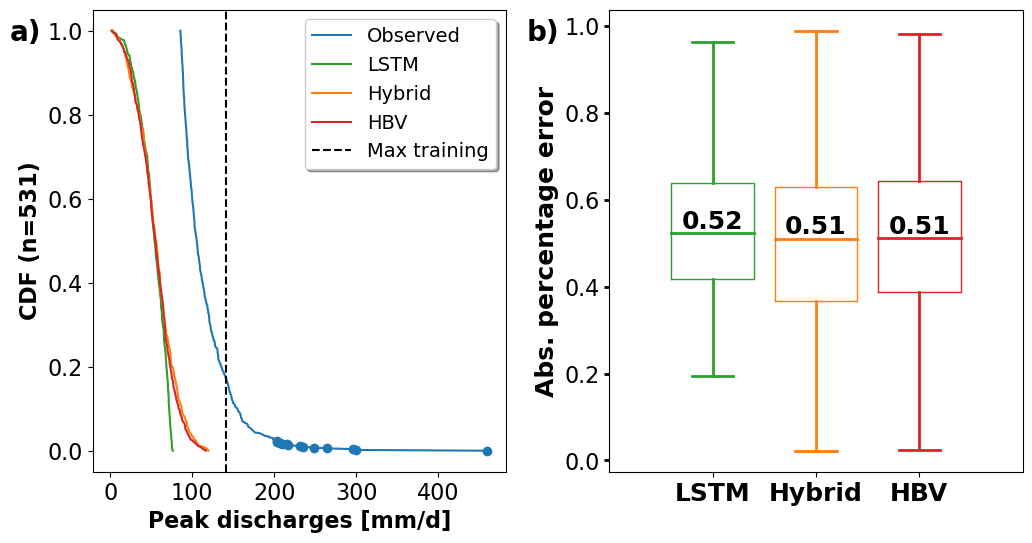

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

df = pd.DataFrame({"observed": highest_peaks,"lstm": highest_peaks_lstm, "hybrid": highest_peaks_hybrid,"hbv": highest_peaks_hbv})
df = df.apply(lambda x: x.sort_values(ascending=False), axis=0, result_type="broadcast")
df["cdf"] = np.arange(len(df)) / (len(df) - 1)

axs[0].plot(df["observed"], df["cdf"], label="Observed", color=color_palette["observed"])
axs[0].scatter(df["observed"][:13], df["cdf"][:13], color=color_palette["observed"])
axs[0].plot(df["lstm"], df["cdf"], label="LSTM", color=color_palette["LSTM"])
axs[0].plot(df["hybrid"], df["cdf"], label="Hybrid", color=color_palette["Hybrid"])
axs[0].plot(df["hbv"], df["cdf"], label="HBV", color=color_palette["HBV"])
axs[0].axvline(x=max(obs_in_training), color="black", linestyle="--", label="Max training")

# Format plot
axs[0].text(-0.2, 0.98, "a)", transform=axs[0].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[0].set_xlabel("Peak discharges [mm/d]", fontsize=16, fontweight="bold")
axs[0].set_ylabel("CDF (n=531)", fontsize=16, fontweight="bold")
axs[0].tick_params(axis="both", which="major", labelsize=16)
axs[0].legend(loc="upper right",fontsize=14, shadow=True)


abs_peaks_error_lstm = abs(highest_peaks-highest_peaks_lstm)/highest_peaks
abs_peaks_error_hybrid = abs(highest_peaks-highest_peaks_hybrid)/highest_peaks
abs_peaks_error_hbv = abs(highest_peaks-highest_peaks_hbv)/highest_peaks

# Create boxplot for LSTM
axs[1].boxplot(abs_peaks_error_lstm, positions=[0.4], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["LSTM"]), 
            medianprops=dict(color=color_palette["LSTM"], linewidth=2),
            whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
            capprops=dict(color=color_palette["LSTM"], linewidth=2))
# Create boxplot for Hybrid
axs[1].boxplot(abs_peaks_error_hybrid, positions=[0.5], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["Hybrid"]), 
            medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
            whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
            capprops=dict(color=color_palette["Hybrid"], linewidth=2))

# Create boxplot for HBV
axs[1].boxplot(abs_peaks_error_hbv, positions=[0.6], showfliers=False, widths=0.08, patch_artist=False, 
            boxprops=dict(color=color_palette["HBV"]), 
            medianprops=dict(color=color_palette["HBV"], linewidth=2),
            whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
            capprops=dict(color=color_palette["HBV"], linewidth=2))

axs[1].text(-0.2, 0.98, "b)", transform=axs[1].transAxes, fontsize=20, fontweight="bold", verticalalignment="top")
axs[1].set_xticks([0.4, 0.5, 0.6], fontsize=18, fontweight="bold")
axs[1].set_xticklabels(["LSTM", "Hybrid", "HBV"], fontsize=18, fontweight="bold") 
axs[1].set_ylabel("Abs. percentage error", fontsize=18, fontweight="bold")
axs[1].tick_params(axis="y", which="major", labelsize=16, width=2)

axs[1].text(0.4, np.median(abs_peaks_error_lstm), f"{np.median(abs_peaks_error_lstm):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")
axs[1].text(0.5, np.median(abs_peaks_error_hybrid), f"{np.median(abs_peaks_error_hybrid):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")
axs[1].text(0.6, np.median(abs_peaks_error_hbv), f"{np.median(abs_peaks_error_hbv):.2f}", horizontalalignment="center", 
         verticalalignment="bottom", fontsize=18, fontweight="bold", color="black")
axs[1].set_xlim(left = 0.3, right=0.7)  

plt.subplots_adjust(wspace=0.25)
plt.savefig("HighestPeakInformation.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

In [16]:
# Highets 10 events: So we can make a more detailed analysis
indices_highest_10 = obs_peaks_testing.argsort()[-10:][::-1]
highest_10_peaks = np.round(obs_peaks_testing[indices_highest_10], 1)
highest_10_peaks_dates = obs_peaks_date_testing[indices_highest_10]
highest_10_peaks_basin = obs_peaks_associated_basin[indices_highest_10]

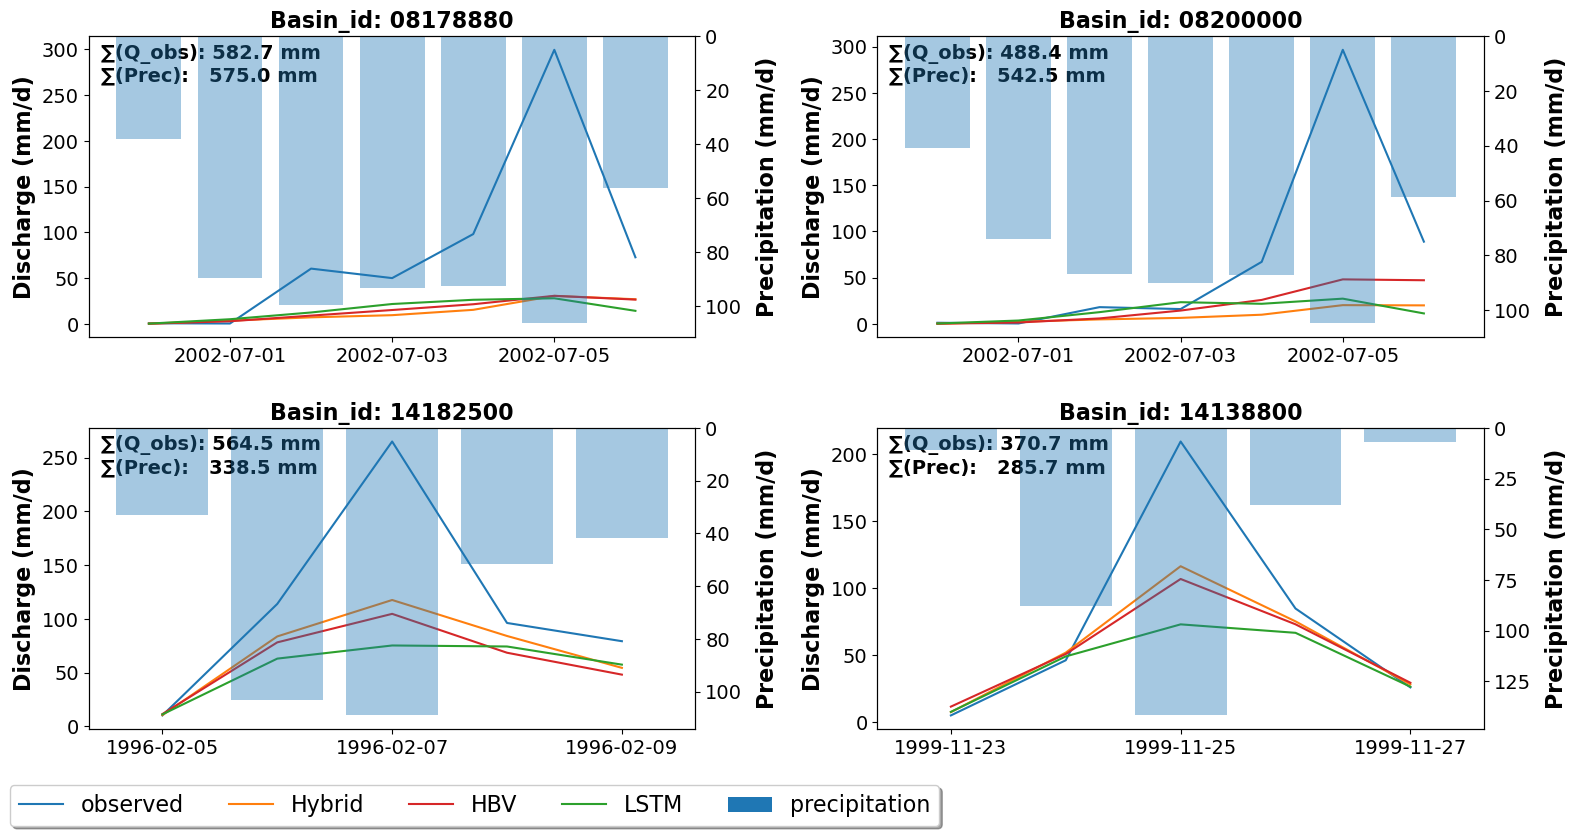

In [17]:
# Dictionary with index of the cases to plot [0-9], and window size for plotting. This was defined manually
extreme_cases ={"1": [5, 1], "2": [5, 1], "3": [2, 2], "9": [2, 2],}

# Create subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(18, 9))
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust space between subplots
axes = axes.flatten()
for i, (case, window) in enumerate(extreme_cases.items()):
    basin_to_analyze = highest_10_peaks_basin[int(case)]
    date_range = pd.date_range(start=highest_10_peaks_dates[int(case)] - datetime.timedelta(days=window[0]), 
                               end=highest_10_peaks_dates[int(case)] + datetime.timedelta(days=window[1]))
    
    df, _ = load_camels_us_forcings(Path(path_data), basin_to_analyze, 'daymet')
    p_series = df['prcp(mm/day)'].loc[date_range]
    acc_p = round(p_series.sum(), 1)

    # Define axis
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    #observed discharge
    q_series = hybrid_results[basin_to_analyze].loc[date_range]["y_obs"]
    acc_q = round(q_series.values.sum(), 1)
    ax1.plot(q_series, color=color_palette["observed"])
    # discharge hybrid
    ax1.plot(hybrid_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["Hybrid"])
   
    # discharge hbv
    ax1.plot(hbv_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["HBV"])
    
    # discharge lstm
    ax1.plot(lstm_results[basin_to_analyze].loc[date_range]["y_sim"], color=color_palette["LSTM"])

    # precipitation
    ax2.bar(date_range, p_series, color=color_palette["observed"],  alpha=0.4)
    
    # Format plot
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # Set interval as needed (e.g., every 2 days)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format the date as desired
    ax1.set_ylabel("Discharge (mm/d)", fontsize=16, fontweight="bold")
    ax1.tick_params(axis="both", which="major", labelsize=14)
    text_str = f'\u2211(Q_obs): {acc_q:0.1f} mm\n\u2211(Prec): {acc_p:>7} mm'
    ax1.text(0.02, 0.85, text_str, transform=ax2.transAxes, fontsize=14, fontweight='bold', color='black' )
    
    ax2.set_ylabel("Precipitation (mm/d)", fontsize=16, fontweight="bold", labelpad=10)
    ax2.tick_params(axis="both", which="major", labelsize=14)
    ax2.invert_yaxis()
    ax1.set_title(f"Basin_id: {basin_to_analyze}", fontsize=16, fontweight="bold")

# Create dummy plots for the legend
ax1.plot([], color=color_palette["observed"], label="observed")
ax1.plot([], color=color_palette["Hybrid"], label="Hybrid")
ax1.plot([], color=color_palette["HBV"], label="HBV")
ax1.plot([], color=color_palette["LSTM"], label="LSTM")
ax1.bar([], [], color=color_palette["observed"], label="precipitation")

# Format plot with a single legend below the subplots
fig.legend(loc="lower left", bbox_to_anchor=(0.075, -0.01), fontsize=16, shadow=True, ncol=5)
plt.savefig("ExtremeEventHydrograph.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

Part 11. Plot graph of errors divided by return period for each lstm. Previously it was using the median of the 
ensemble

In [18]:
# LSTM model -------------------------------------------------------------------------------------------------------
lstm_ensemble_peaks_per_basin = {}
for basin, peak_info in obs_peaks_per_basin.items():
    ensemble_peaks = {}
    for i in range(1,len(path_results_LSTM)+1): 
        max_value = []
        for date in peak_info["date"]:
            window_df = lstm_results[basin][f'y_sim_ens_{i}'].loc[date-pd.Timedelta(days=tolerance):
                                                                  date+pd.Timedelta(days=tolerance)]
            max_value.append(window_df.loc[window_df.idxmax()])
            
        ensemble_peaks[f'member_{i}'] = max_value
    
    lstm_ensemble_peaks_per_basin[basin] = ensemble_peaks

In [19]:
# Calculate peak errors for all the models
perc_error_peaks = {}
for basin, peak_info in obs_peaks_per_basin.items():
    errors_per_model = {}
    obs_peaks = peak_info["value"]
    hybrid_peaks =  np.array(hybrid_peaks_per_basin[basin]["value"])
    errors_per_model["Hybrid"]= np.abs(obs_peaks-hybrid_peaks)/obs_peaks
    
    hbv_peaks =  np.array(hbv_peaks_per_basin[basin]["value"])
    errors_per_model["HBV"]= np.abs(obs_peaks-hbv_peaks)/obs_peaks
    
    for i in range(1,len(path_results_LSTM)+1):
        lstm_peaks = np.array(lstm_ensemble_peaks_per_basin[basin][f"member_{i}"])
        errors_per_model[f"LSTM_{i}"]= np.abs(obs_peaks-lstm_peaks)/obs_peaks

    perc_error_peaks[basin] = errors_per_model

In [20]:
# Models
model_name =  ["Hybrid", "HBV"]
for i in range(1,len(path_results_LSTM)+1):
    model_name.append(f"LSTM_{i}")

# Return periods
error_per_TR = {}
for TR in TR_range :
    error_per_TR[TR] = []

# Intialize structure to save error per model and per return period
error_per_model = {model: {TR: [] for TR in TR_range} for model in model_name}

# Process and store the error per model per return period
for basin, peak_error_per_model in perc_error_peaks.items():
    for model in peak_error_per_model.keys():
        for i, TR in enumerate(TR_range):
            error_per_model[model][TR].extend(peak_error_per_model[model][classified_peaks[basin]==i+1])

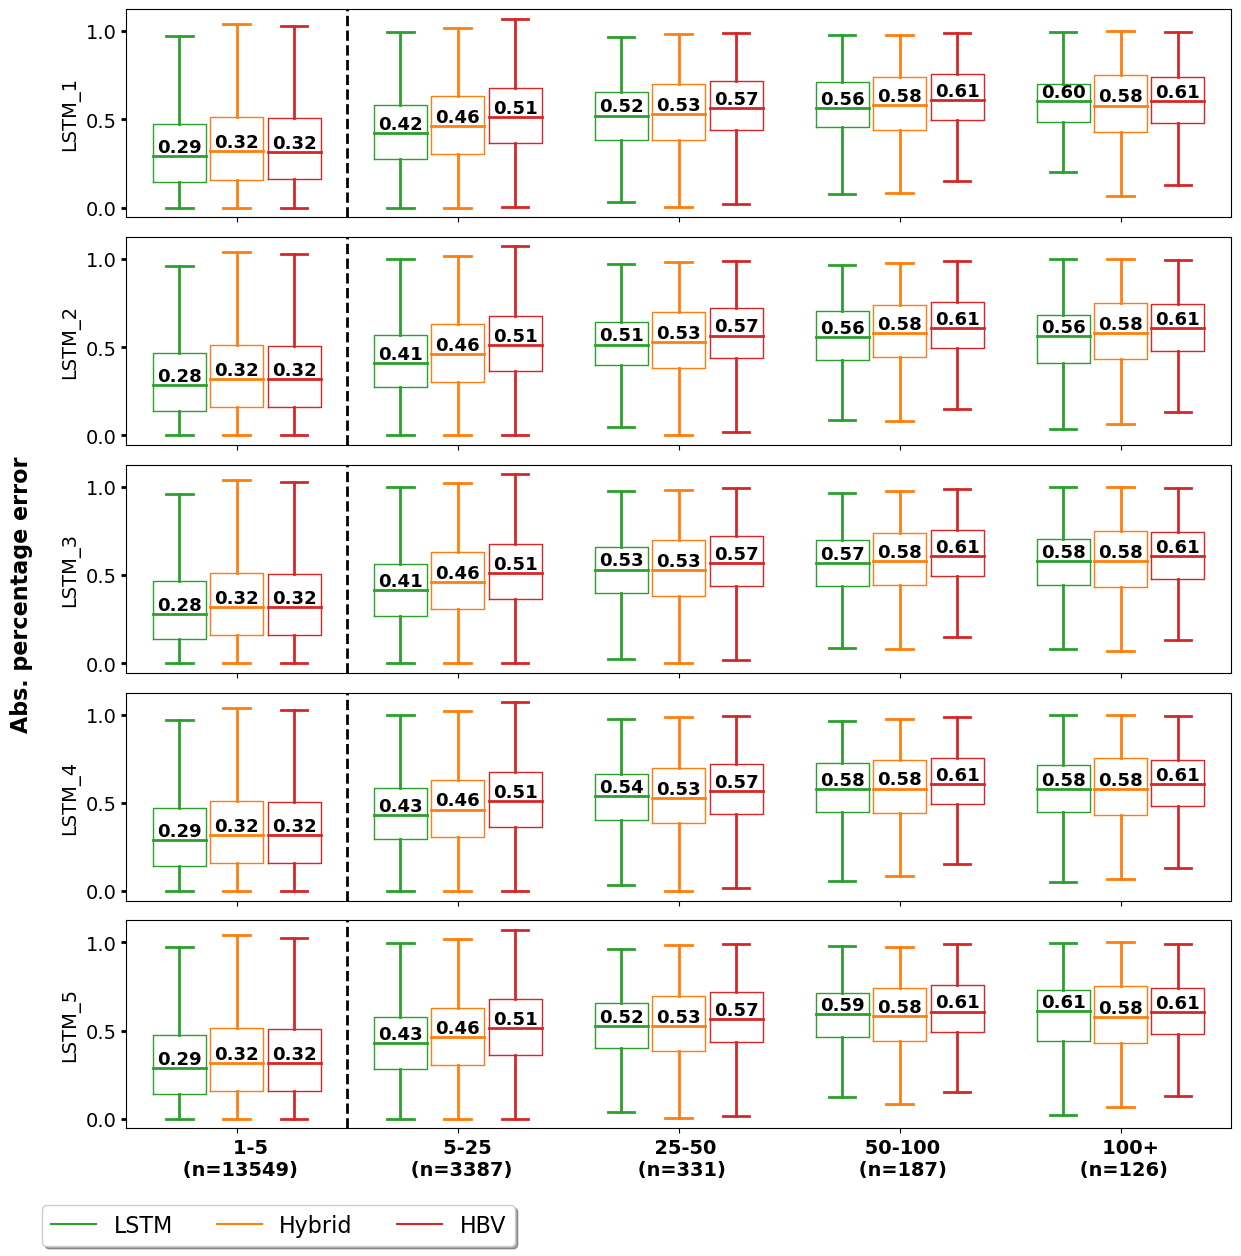

In [21]:
# Assuming ri_list is a dictionary containing data for different models
step = 0.5
bin_names = [f"{TR_range[i]:>7}\n (n={len(value)})" for i, (_, value) in enumerate(error_per_model['Hybrid'].items())]
x = np.arange(0, len(list(bin_names))*step, step)  # the label locations
width = 0.13  # Width of each boxplot

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)  # 2 rows, 2 columns
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i in range(len(path_results_LSTM)):
    # Iterate through each bin_name and create boxplots for each model
    for j, TR in enumerate(TR_range):
        # LSTM boxplots
        errors_lstm = error_per_model[f"LSTM_{i+1}"][TR]
        axs[i].boxplot(errors_lstm, 
                       positions=[x[j] - width], showfliers=False, widths=0.12, patch_artist=False, 
                       boxprops=dict(color=color_palette["LSTM"]), 
                       medianprops=dict(color=color_palette["LSTM"], linewidth=2),
                       whiskerprops=dict(color=color_palette["LSTM"], linewidth=2),
                       capprops=dict(color=color_palette["LSTM"], linewidth=2))
        
        axs[i].text(x[j] - width, np.median(errors_lstm), f"{np.median(errors_lstm):.2f}", horizontalalignment="center", 
                    verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
        
        # Hybrid boxplots
        errors_hybrid = error_per_model["Hybrid"][TR]
        axs[i].boxplot(errors_hybrid, 
                       positions=[x[j]], showfliers=False, widths=0.12, patch_artist=False, 
                       boxprops=dict(color=color_palette["Hybrid"]), 
                       medianprops=dict(color=color_palette["Hybrid"], linewidth=2),
                       whiskerprops=dict(color=color_palette["Hybrid"], linewidth=2),
                       capprops=dict(color=color_palette["Hybrid"], linewidth=2))
        
        axs[i].text(x[j], np.median(errors_hybrid), f"{np.median(errors_hybrid):.2f}", horizontalalignment="center", 
                    verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
        
        # HBV boxplots
        errors_hbv = error_per_model["HBV"][TR]
        axs[i].boxplot(errors_hbv, 
                       positions=[x[j] + width], showfliers=False, widths=0.12, patch_artist=False, 
                       boxprops=dict(color=color_palette["HBV"]), 
                       medianprops=dict(color=color_palette["HBV"], linewidth=2),
                       whiskerprops=dict(color=color_palette["HBV"], linewidth=2),
                       capprops=dict(color=color_palette["HBV"], linewidth=2))
        
        axs[i].text(x[j] + width, np.median(errors_hbv), f"{np.median(errors_hbv):.2f}", horizontalalignment="center", 
                    verticalalignment="bottom", fontsize=13, fontweight="bold", color="black")
    
    # Line dividing interpolation - extrapolation errors
    axs[i].axvline(x=0.25, color="black", linestyle="--", linewidth=2)

    # Add labels, titles, legends, etc. as needed
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(bin_names, fontsize=14, fontweight="bold")
    axs[i].set_xlim(left = x[0]-step/2, right=x[-1]+step/2)  
    axs[i].set_yticks([0, 0.5, 1])
    axs[i].set_ylabel(f'LSTM_{i+1}', fontsize=14)
    axs[i].tick_params(axis='y', labelsize=14, width=2)

# Set y-label for the middle row on the left side
fig.text(-0.03, 0.5, 'Abs. percentage error', va='center', rotation='vertical', fontsize=16, fontweight='bold')
# Create a single legend at the bottom
# Dummy plots for the legend
handles = [
    plt.Line2D([], [], color=color_palette["LSTM"], label="LSTM"),
    plt.Line2D([], [], color=color_palette["Hybrid"], label="Hybrid"),
    plt.Line2D([], [], color=color_palette["HBV"], label="HBV")
]

fig.legend(handles=handles, bbox_to_anchor=(0.4, 0), fontsize=16, shadow=True, ncol=3)

plt.tight_layout()
plt.savefig("PeakError_per_return_period_ensemble.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()


Part 12. Theoretical prediction limit LSTM

In [22]:
# Read trained lstm model
for i, ensemble_member in enumerate(path_results_LSTM):
    path_config = Path(ensemble_member+"/config.yml")
    path_model = ensemble_member+"/model_epoch020.pt"
    path_scaler = Path(ensemble_member+"/train_data/train_data_scaler.yml")

    # Read scaler
    scaler_file = Path("../experiments/runs/lstm_extrapolation_0307_161850/train_data/train_data_scaler.yml")
    with scaler_file.open("r") as fp:
        yaml = YAML(typ="safe")
        scaler_dump = yaml.load(fp)

    scaler = {}
    for key, value in scaler_dump.items():
        if key in ["attribute_means", "attribute_stds", "camels_attr_means", "camels_attr_stds"]:
            scaler[key] = pd.Series(value)
        elif key in ["xarray_feature_scale", "xarray_feature_center"]:
            scaler[key] = xarray.Dataset.from_dict(value).astype(np.float32)

    Q_mean = scaler["xarray_feature_center"]["QObs(mm/d)"].item()
    Q_std = scaler["xarray_feature_scale"]["QObs(mm/d)"].item()

    # Read model
    lstm_model = CudaLSTM(Config(path_config))
    lstm_model.load_state_dict(torch.load(path_model, map_location="cpu"))

    # Calculate theoretical prediction limit
    linear_layer = lstm_model.head.net[0]
    # Convert weights and bias to numpy arrays if needed
    theoretical_limit = (np.sum(np.abs(linear_layer.weight.data.numpy()))+linear_layer.bias.data.numpy())*Q_std+Q_mean
    
    # Maximum value predicted during testing
    lstm_peaks_testing = []
    for _, value in lstm_ensemble_peaks_per_basin.items():
        lstm_peaks_testing.extend(value[f'member_{i+1}'])
    
    print(f'Ensemble member {i+1}: Maximum theoretical limit: {"%.1f "% theoretical_limit[0]:>3}mm | Highest simulated peak: {"%.1f "% max(lstm_peaks_testing):>3}mm')

Ensemble member 1: Maximum theoretical limit: 83.9 mm | Highest simulated peak: 78.9 mm
Ensemble member 2: Maximum theoretical limit: 81.3 mm | Highest simulated peak: 76.5 mm
Ensemble member 3: Maximum theoretical limit: 81.9 mm | Highest simulated peak: 76.9 mm
Ensemble member 4: Maximum theoretical limit: 82.1 mm | Highest simulated peak: 76.5 mm
Ensemble member 5: Maximum theoretical limit: 81.4 mm | Highest simulated peak: 76.0 mm
